# Handwritten Arabic Digits & Letters Recognition

## Submitted To Dr. Ghada Khoriba

### **Contributers:**
#### * **Nour Nasser**
#### * **Abdalrahman Hassan**
#### * **Ramez Shakran** 
#### * **Hussien Ehab** 
#### * **Mahmoud Ibrahim** 

## Data Exploration


1. Import libraries


In [61]:
# Import main libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display
import csv
from PIL import Image
from scipy.ndimage import rotate
import keras as keras
import tensorflow as tf
%matplotlib inline

### Loading Arabic Letters Dataset

In [62]:
# Loading dataset into dataframes
training_letters_images = pd.read_csv('training images.csv')
training_letters_labels = pd.read_csv('training labels.csv')
testing_letters_images = pd.read_csv('testing images.csv')
testing_letters_labels = pd.read_csv('testing labels.csv')

# print statistics about the dataset
print("There are %d training arabic letter images of 64x64 pixels." %training_letters_images.shape[0])
print("There are %d testing arabic letter images of 64x64 pixels." %testing_letters_images.shape[0])
training_letters_images.head()

There are 13439 training arabic letter images of 64x64 pixels.
There are 3359 testing arabic letter images of 64x64 pixels.


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.3438,0.3439,0.3440,0.3441,0.3442,0.3443,0.3444,0.3445,0.3446,0.3447
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Loading Arabic Digits Dataset

In [63]:
# Loading dataset into dataframes
training_digits_images = pd.read_csv("training digits images.csv")
training_digits_labels = pd.read_csv("training digits labels.csv")
testing_digits_images = pd.read_csv("testing digits images.csv")
testing_digits_labels = pd.read_csv("testing digits labels.csv")

# print statistics about the dataset
print("There are %d training arabic digit images of 64x64 pixels." %training_digits_images.shape[0])
print("There are %d testing arabic digit images of 64x64 pixels." %testing_digits_images.shape[0])

There are 59999 training arabic digit images of 64x64 pixels.
There are 9999 testing arabic digit images of 64x64 pixels.


### Convert csv values to an image 
Writting a method to be used later if we want visualization of an image from its pixels values.

In [64]:
from scipy.ndimage import rotate

# Define function and its arguments
def convertValuesToImages(image_values, display=False):
    # Convert input values to numpy array with uint8 data type and reshape to (64, 64) shape
    image_array = np.array(image_values, dtype=np.uint8).reshape(64, 64)

    # Apply flip and rotation transformations to the input image array
    # Flip along the vertical axis and rotate by 90 degrees clockwise
    modified_image = np.rot90(np.fliplr(image_array))

    # Display the modified image if the display argument is set to True
    if display:
        Image.fromarray(modified_image).show()

    # Convert the modified image array to a PIL image object and return it
    return Image.fromarray(modified_image)

### Visualizing some examples

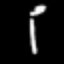

In [65]:
convertValuesToImages(training_letters_images.loc[0], True)

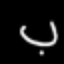

In [66]:
convertValuesToImages(training_letters_images.loc[12], True)

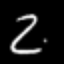

In [67]:
convertValuesToImages(training_letters_images.loc[37], True)

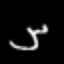

In [68]:
convertValuesToImages(training_letters_images.loc[3000], True)

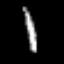

In [69]:
convertValuesToImages(training_digits_images.loc[0], True)

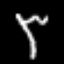

In [70]:
convertValuesToImages(training_digits_images.loc[2], True)

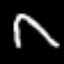

In [71]:
convertValuesToImages(training_digits_images.loc[7], True)

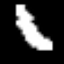

In [72]:
convertValuesToImages(training_digits_images.loc[9], True)

## Data Preprocessing

### Image Normalization
We rescale the images by dividing every pixel in the image by 255 to make them into range [0, 1]

In [73]:
training_digits_images_scaled = training_digits_images.values.astype('float32')/255
training_digits_labels = training_digits_labels.values.astype('int32')
testing_digits_images_scaled = testing_digits_images.values.astype('float32')/255
testing_digits_labels = testing_digits_labels.values.astype('int32')

training_letters_images_scaled = training_letters_images.values.astype('float32')/255
training_letters_labels = training_letters_labels.values.astype('int32')
testing_letters_images_scaled = testing_letters_images.values.astype('float32')/255
testing_letters_labels = testing_letters_labels.values.astype('int32')

In [74]:
print("Training images of digits after scaling")
print(training_digits_images_scaled.shape)
training_digits_images_scaled[0:5]

Training images of digits after scaling
(59999, 4096)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [75]:
print("Training images of letters after scaling")
print(training_letters_images_scaled.shape)
training_letters_images_scaled[0:5]

Training images of letters after scaling
(13439, 4096)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Encoding Categorical Labels
From the labels csv files we can see that labels are categorical values and it is a multi-class classification problem. 

Our outputs are in the form of:
* Digits from 0 to 9 have categories numbers from 0 to 9
* Letters from ’alef’ to ’yeh’ have categories numbers from 10 to 37

**Here we will encode these categories values using One Hot Encoding with keras.**

One-hot encoding transforms integer to a binary matrix where the array contains only one ‘1’ and the rest elements are ‘0’.



In [76]:
from keras.utils import to_categorical

number_of_classes = 38
training_letters_labels_encoded = to_categorical(training_letters_labels, num_classes=number_of_classes)
testing_letters_labels_encoded = to_categorical(testing_letters_labels, num_classes=number_of_classes)
training_digits_labels_encoded = to_categorical(training_digits_labels, num_classes=number_of_classes)
testing_digits_labels_encoded = to_categorical(testing_digits_labels, num_classes=number_of_classes)

In [77]:
print(training_digits_labels_encoded)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [78]:
print(training_letters_labels_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Reshaping Input Images to 64x64x1


**we will reshape the input images to a 4D tensor with shape
(nb_samples, 64, 64 ,1)** as we use grayscale images of 64x64 pixels.

In [79]:
# reshape input digit images to 64x64x1
training_digits_images_scaled = training_digits_images_scaled.reshape([-1, 64, 64, 1])
testing_digits_images_scaled = testing_digits_images_scaled.reshape([-1, 64, 64, 1])

# reshape input letter images to 64x64x1
training_letters_images_scaled = training_letters_images_scaled.reshape([-1, 64, 64, 1])
testing_letters_images_scaled = testing_letters_images_scaled.reshape([-1, 64, 64, 1])

print(training_digits_images_scaled.shape, training_digits_labels_encoded.shape, testing_digits_images_scaled.shape, testing_digits_labels_encoded.shape)
print(training_letters_images_scaled.shape, training_letters_labels_encoded.shape, testing_letters_images_scaled.shape, testing_letters_labels_encoded.shape)

(59999, 64, 64, 1) (59999, 38) (9999, 64, 64, 1) (9999, 38)
(13439, 64, 64, 1) (13439, 38) (3359, 64, 64, 1) (3359, 38)


### Merging Letters and Digits Datasets

In [80]:
training_data_images = np.concatenate((training_digits_images_scaled, training_letters_images_scaled), axis=0) 
training_data_labels = np.concatenate((training_digits_labels_encoded, training_letters_labels_encoded), axis=0)
print("Total Training images are {} images of shape".format(training_data_images.shape[0]))
print(training_data_images.shape, training_data_labels.shape)


testing_data_images = np.concatenate((testing_digits_images_scaled, testing_letters_images_scaled), axis=0) 
testing_data_labels = np.concatenate((testing_digits_labels_encoded, testing_letters_labels_encoded), axis=0)
print("Total Testing images are {} images of shape".format(testing_data_images.shape[0]))
print(testing_data_images.shape, testing_data_labels.shape)


Total Training images are 73438 images of shape
(73438, 64, 64, 1) (73438, 38)
Total Testing images are 13358 images of shape
(13358, 64, 64, 1) (13358, 38)


## Designing Model Architecture

Now we will make a method which creates the model architecture with the specified optimizer and activation functions.

In [81]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

def create_model(optimizer='adam', kernel_initializer='he_normal', activation='relu'):
  # create model
  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(64, 64, 1), kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(GlobalAveragePooling2D())
  
  #Fully connected final layer
  model.add(Dense(38, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
  return model

* The first layer is a convolutional layer with 16 feature maps and a 3x3 size. It has a relu activation function and is the input layer for images.
* The second layer is Batch Normalization, which helps with faster learning and higher accuracy by solving distribution issues 
* The third layer is the MaxPooling layer, which reduces overfitting and the number of parameters to learn, and the training time.
* The next layer is a Regularization layer using dropout to reduce overfitting.
* Another hidden layer with 32 feature maps with the size of 3×3 and a relu activation function to capture more features from the image.
* OThere are other hidden layers with varying feature maps and activation functions to capture patterns from the image.
* More MaxPooling, Batch Normalization, Regularization and GlobalAveragePooling2D layers.
* The last layer is the output layer with 10 neurons using softmax activation function for multi-class classification

**Categorical_crossentropy is used as the loss function as this is multi-class classification problem and accuracy is used as metrics for improved performance.**


## Model Summary And Visualization

In [82]:
model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)      

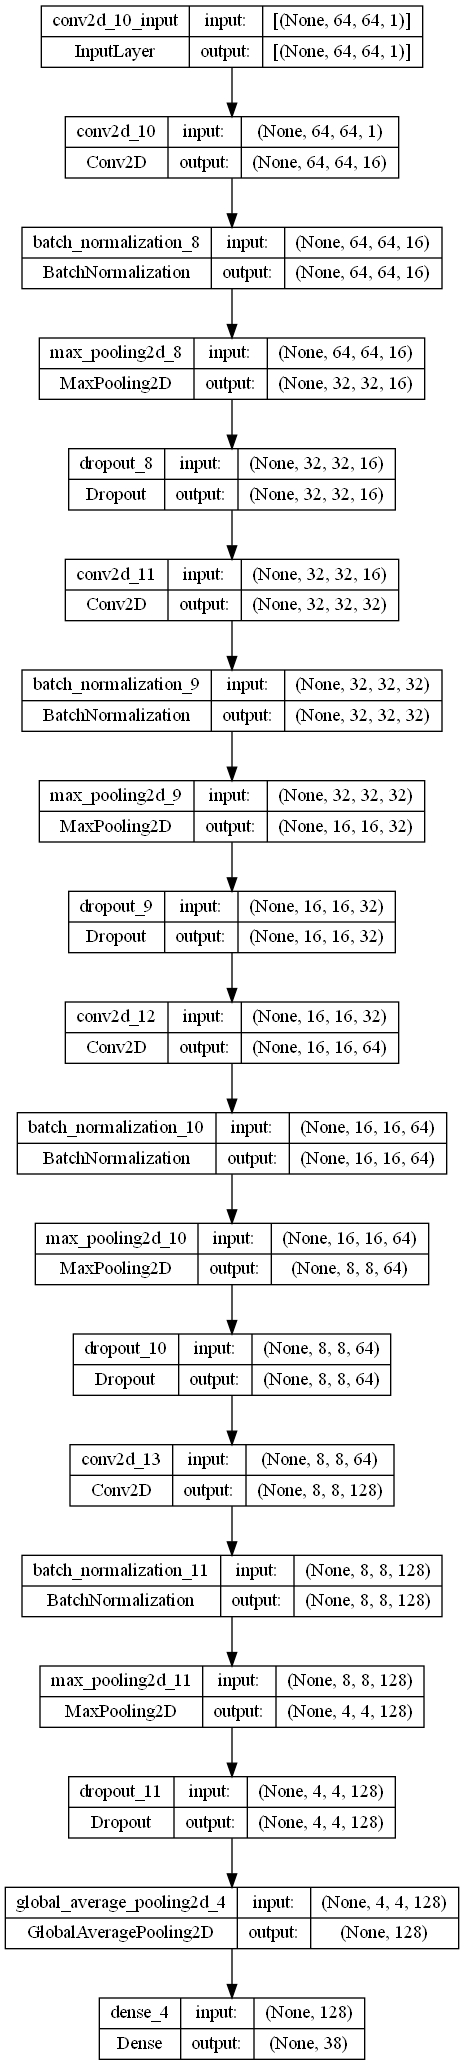

In [83]:
from keras.utils import plot_model

plot_model(model, to_file="model.png", show_shapes=True)
from IPython.display import Image as IPythonImage
display(IPythonImage('model.png'))

## Parameters Tuning

We will tune the parameters optimizer, kernel_initializer and activation using Grid Search.

In [84]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define the parameters
optimizer = ['RMSprop', 'Adam', 'Adagrad', 'Nadam']
kernel_initializer = ['normal', 'uniform']
activation = ['relu', 'linear', 'tanh']

param_grid = dict(optimizer=optimizer, kernel_initializer=kernel_initializer, activation=activation)

# count number of different parameters values combinations
parameters_number = 1
for x in param_grid:
  parameters_number = parameters_number * len(param_grid[x]) 
print("Number of different parameter combinations = {}".format(parameters_number))

Number of different parameter combinations = 24


We will try different models with different parameters to find the best parameter values.

In [ ]:
epochs = 5
batch_size = 20

#creating the models with different hyperparameters
for a,b,c in [(x,y,z) for x in optimizer for z in activation for y in kernel_initializer]:
    params = {'optimizer' : a , 'kernel_initializer' : b , 'activation' : c}
    print(params)
    curr_model = create_model(a, b, c)
    curr_model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=epochs, batch_size=batch_size, verbose=1)
    print("=============================================================================")

**Considering the results above, it was found the the best parameters are:**
* **Optimizer: Adam**
* **Kernel_initializer: uniform**
* **Activation: relu** 

In [85]:
#creating the model with the best parameters
model = create_model(optimizer='Adam', kernel_initializer='uniform', activation='relu')

## Training the Mode

### Fitting the Model


In [86]:
from keras.callbacks import ModelCheckpoint  

#The ModelCheckpoint callback is being used to save the weights of the trained model to a file
#This allows the model to be reused later without having to train it again. 
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
history = model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=10, batch_size=20, verbose=1, callbacks=[checkpointer])

Epoch 1/10
3672/3672 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.9106
Epoch 1: val_loss improved from inf to 0.24870, saving model to weights.hdf5
3672/3672 [==============================] - 108s 29ms/step - loss: 0.3292 - accuracy: 0.9106 - val_loss: 0.2487 - val_accuracy: 0.9135
Epoch 2/10
3671/3672 [============================>.] - ETA: 0s - loss: 0.1079 - accuracy: 0.9676
Epoch 2: val_loss improved from 0.24870 to 0.23943, saving model to weights.hdf5
3672/3672 [==============================] - 135s 37ms/step - loss: 0.1079 - accuracy: 0.9676 - val_loss: 0.2394 - val_accuracy: 0.9509
Epoch 3/10
3671/3672 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9753
Epoch 3: val_loss did not improve from 0.23943
3672/3672 [==============================] - 110s 30ms/step - loss: 0.0789 - accuracy: 0.9754 - val_loss: 0.3824 - val_accuracy: 0.8706
Epoch 4/10
3670/3672 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.

### Plotting Loss and Accuracy Curves with Epochs

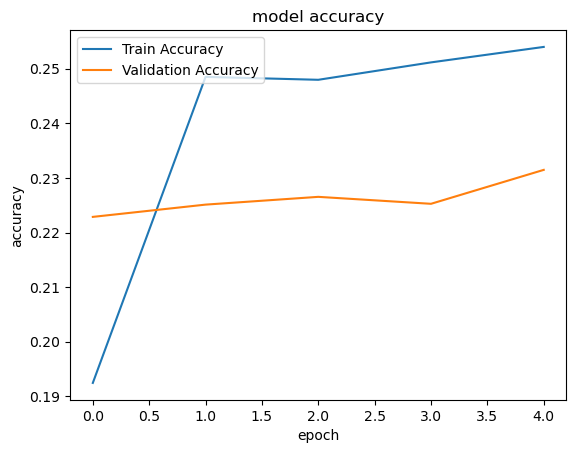

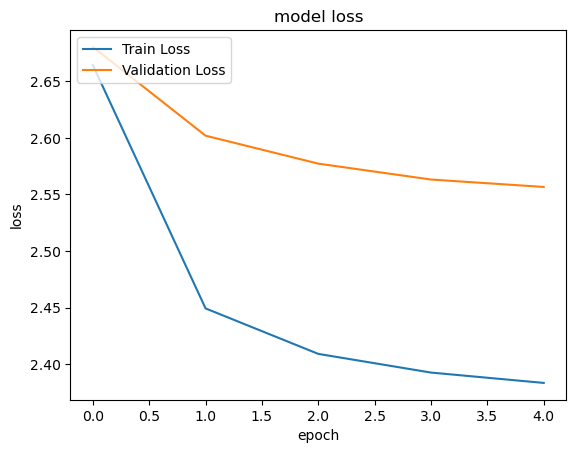

In [58]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

### Load the Model with the Best Validation Loss


In [87]:
model.load_weights('weights.hdf5')

## Testing the Model

In [88]:
# Final evaluation of the model
metrics = model.evaluate(testing_data_images, testing_data_labels, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

418/418 [==============================] - 4s 10ms/step - loss: 0.0518 - accuracy: 0.9853
Test Accuracy: 0.9853271245956421
Test Loss: 0.051788732409477234


## Training our best model with Increasing the number of epochs to see if we get a better accuracy

In [89]:
epochs = 15
batch_size = 20

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[checkpointer])
          
model.load_weights('weights.hdf5')

Epoch 1/15
3670/3672 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9850
Epoch 1: val_loss improved from inf to 0.25041, saving model to weights.hdf5
3672/3672 [==============================] - 104s 28ms/step - loss: 0.0473 - accuracy: 0.9850 - val_loss: 0.2504 - val_accuracy: 0.9263
Epoch 2/15
3670/3672 [============================>.] - ETA: 0s - loss: 0.0450 - accuracy: 0.9855
Epoch 2: val_loss improved from 0.25041 to 0.06800, saving model to weights.hdf5
3672/3672 [==============================] - 106s 29ms/step - loss: 0.0450 - accuracy: 0.9856 - val_loss: 0.0680 - val_accuracy: 0.9793
Epoch 3/15
3671/3672 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9865
Epoch 3: val_loss improved from 0.06800 to 0.05378, saving model to weights.hdf5
3672/3672 [==============================] - 103s 28ms/step - loss: 0.0427 - accuracy: 0.9865 - val_loss: 0.0538 - val_accuracy: 0.9845
Epoch 4/15
3670/3672 [============================>.] - ETA

## Testing our model after training on 15 epochs

In [91]:
# Final evaluation of the model
metrics = model.evaluate(testing_data_images, testing_data_labels, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

418/418 [==============================] - 7s 17ms/step - loss: 0.0457 - accuracy: 0.9877
Test Accuracy: 0.9877226948738098
Test Loss: 0.045695479959249496


After training the model on more 15 epochs we got a better accuracy . Also the test accuracy imorpved from from **98.286% to 98.82%** and we think that increasing the number of epochs even more may slightly improve the accuracy 




In [30]:
model_json =model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [31]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Comparing our model with simple vanilla cnn model on the same data

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense

def create_model():
    # Define the vanilla model architecture
    vanillaModel = Sequential()
    vanillaModel.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(64, 64, 1), activation='relu')) # Input layer
    vanillaModel.add(GlobalAveragePooling2D())
    vanillaModel.add(Dense(38, activation = 'softmax')) # Output layer => output dimension = 38 as it is multi-class

    # Compile the model
    vanillaModel.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')
    return vanillaModel

def train_model(model, train_images, train_labels, epochs, batch_size, test_images, test_labels):
    # Train the model
    history = model.fit(train_images, train_labels, 
                  validation_data=(test_images, test_labels),
                  epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluate the model on the test set
    metrics = model.evaluate(test_images, test_labels, verbose=1)
    print("Model Test Accuracy: {}".format(metrics[1]))
    print("Model Test Loss: {}".format(metrics[0]))
    return history

# Train the vanilla model using the created functions
epochs = 5
batch_size = 20
vanillaModel = create_model()
history = train_model(vanillaModel, training_data_images, training_data_labels, epochs, batch_size, testing_data_images, testing_data_labels)

Epoch 1/5
3672/3672 [==============================] - 54s 15ms/step - loss: 2.6643 - accuracy: 0.1925 - val_loss: 2.6803 - val_accuracy: 0.2229
Epoch 2/5
3672/3672 [==============================] - 25s 7ms/step - loss: 2.4494 - accuracy: 0.2485 - val_loss: 2.6019 - val_accuracy: 0.2251
Epoch 3/5
3672/3672 [==============================] - 25s 7ms/step - loss: 2.4092 - accuracy: 0.2480 - val_loss: 2.5772 - val_accuracy: 0.2265
Epoch 4/5
3672/3672 [==============================] - 26s 7ms/step - loss: 2.3927 - accuracy: 0.2512 - val_loss: 2.5632 - val_accuracy: 0.2253
Epoch 5/5
418/418 [==============================] - 1s 3ms/step - loss: 2.5566 - accuracy: 0.2315
Model Test Accuracy: 0.23147177696228027
Model Test Loss: 2.556628942489624


We get test accuracy of **23.15%** from the baseline Model (vanilla). so our project outperfomed it as our test accuracy were **98.82%**

## Predict Image Classes

In [98]:
import numpy as np
# getting the predictions and true labels for the input data of the model 
def get_predicted_classes(model, data, labels=None):
    image_predictions = model.predict(data)
    predicted_classes = np.argmax(image_predictions, axis=1)
    if labels is not None:
        true_classes = np.argmax(labels, axis=1)
    return predicted_classes, true_classes

## Comparing Evaluation Metrics between Vanilla CNN Model and Our Final Model


In [49]:
!pip install joblib
!pip install threadpoolctl

In [50]:
from sklearn.metrics import classification_report
# import joblib

def get_classification_report(y_true, y_pred):
  print(classification_report(y_true, y_pred))

In [51]:
y_pred, y_true = get_predicted_classes(model, testing_data_images, testing_data_labels)
get_classification_report(y_true, y_pred)

418/418 [==============================] - 4s 9ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       999
           1       0.99      1.00      0.99      1000
           2       0.98      1.00      0.99      1000
           3       1.00      0.99      0.99      1000
           4       1.00      1.00      1.00      1000
           5       0.99      0.99      0.99      1000
           6       0.99      0.99      0.99      1000
           7       1.00      1.00      1.00      1000
           8       0.99      1.00      1.00      1000
           9       1.00      1.00      1.00      1000
          10       0.98      1.00      0.99       119
          11       1.00      0.99      1.00       120
          12       0.90      0.97      0.94       120
          13       0.99      0.92      0.95       120
          14       0.98      0.99      0.99       120
          15       0.96      0.98      0.97       120
          16       1.00   

In [52]:
y_pred, y_true = get_predicted_classes(vanillaModel, testing_data_images, testing_data_labels)
get_classification_report(y_true, y_pred)

418/418 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       999
           1       0.20      0.76      0.32      1000
           2       0.12      0.30      0.18      1000
           3       0.00      0.00      0.00      1000
           4       0.13      0.18      0.15      1000
           5       0.43      0.50      0.46      1000
           6       0.14      0.29      0.19      1000
           7       0.00      0.00      0.00      1000
           8       0.18      0.29      0.23      1000
           9       0.00      0.00      0.00      1000
          10       0.00      0.00      0.00       119
          11       0.00      0.00      0.00       120
          12       0.00      0.00      0.00       120
          13       0.00      0.00      0.00       120
          14       0.00      0.00      0.00       120
          15       0.00      0.00      0.00       120
          16       0.00   

C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)